# 텍스트 분류 실습 - 20 뉴스그룹 분류
#### 사이킷런 내부에 가지고 있는 20 뉴스그룹 데이터 세트를 이용해 텍스트 분류를 적용할 것이다.
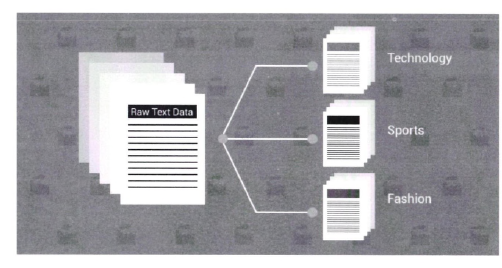
#### 텍스트를 피처 벡터화로 변환하면 일반적으로 희소 행렬 형태가 된다. 이런 희소 행렬 분류에 효과적인 알고리즘은 로지스틱 회귀, 선형 서포트 벡터 머신, 나이브 베이즈 등이 있다. 이 중 로지스틱 회귀를 이용해서 분류를 수행한다.
#### 텍스트를 기반으로 분류를 수행할 때 먼저 텍스트를 정규화 후 피처 벡터화를 적용한다. 그 이후 적합한 머신러닝 알고리즘을 적용해 분류를 학습/예측/평가한다.
#### 이번에는 카운터 기반과 TF-IDF 기반의 벡터화 성능 비교, 피처 벡터화를 위한 파라미터와 GridSearchCV 기반의 하이퍼 파라미터 튜닝, 그리고 사이킷런의 Pipeline 객체를 통한 피처 벡터화 파라미터와 GridSearchCV 기반의 하이퍼 파라미터 튜닝을 진행한다.

## 텍스트 정규화

In [1]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', random_state=156)

In [4]:
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [5]:
import pandas as pd

print('target 클래스의 값과 분포도 \n',pd.Series(news_data.target).value_counts().sort_index())
print('target 클래스의 이름들 \n',news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
print(news_data.data[0])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

#### 텍스트 데이터를 확인해 보면,  뉴스그룹 기사의 내용뿐만 아니라 뉴스그룹 제목, 작성자, 소속, 이메일 등의 다양한 정보들이 있다. 이 중에서 내용을 제외하고 제목 등의 다른 정보는 제거한다.
#### 왜냐하면, 제목과 소속/이메일 정보 등의 헤더와 푸터 정보들은 분류의 Target 클래스 값과 유사해서 텍스트 분석의 의도에 벗어나기 떄문이다.

In [7]:
from sklearn.datasets import fetch_20newsgroups

# subset='train'으로 학습용(Train) 데이터만 추출, remove=('headers', 'footers', 'quotes')로 내용만 추출
train_news= fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=156)
X_train = train_news.data
y_train = train_news.target
print(type(X_train))

# subset='test'으로 테스트(Test) 데이터만 추출, remove=('headers', 'footers', 'quotes')로 내용만 추출
test_news= fetch_20newsgroups(subset='test',remove=('headers', 'footers','quotes'),random_state=156)
X_test = test_news.data
y_test = test_news.target
print('학습 데이터 크기 {0} , 테스트 데이터 크기 {1}'.format(len(train_news.data) , len(test_news.data)))

<class 'list'>
학습 데이터 크기 11314 , 테스트 데이터 크기 7532


## 피처 벡터화 변환과 머신러닝 모델 학습/예측/평가
#### CountVectorizer를 이용해 학습 데이터의 텍스트를 피처 벡터화를 진행한다. 테스트 데이터에 대해서도 진행하는데 한 가지 유의할 점은 테스트 데이터에 적용할 때 반드시 학습 데이터를 이용해 fit()이 수행된 CountVectorizer 객체를 이용해 변환해야 한다.
#### 그리고 테스트 데이터의 피처 벡터화 시 fit_transform()을 사용하면 안된다.
#### 왜냐하면, 학습 시 사용된 피처 개수와 예측 시 사용할 피처 개수가 달라지기 때문이다.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)
X_train_cnt_vect = cnt_vect.transform(X_train)

# 유의할 점 : fit()이 진행된 객체에 대해서 transform 진행
X_test_cnt_vect = cnt_vect.transform(X_test)

print('학습 데이터 Text의 CountVectorizer Shape:',X_train_cnt_vect.shape)

학습 데이터 Text의 CountVectorizer Shape: (11314, 101631)


#### 이렇게 피처 벡터화된 데이터에 로지스틱 회귀를 적용해 뉴스그룹에 대한 분류를 예측해보자.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# LogisticRegression을 이용하여 학습/예측/평가 수행. 
# LogisticRegression의 solver를 기본값인 lbfgs이 아닌 liblinear로 설정해야 학습이 오래 걸리지 않음. 
lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train_cnt_vect , y_train)
pred = lr_clf.predict(X_test_cnt_vect)

print('CountVectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

CountVectorized Logistic Regression 의 예측 정확도는 0.617


#### Count 기반 로지스틱 회귀의 예측 정확도는 약 0.61이다. 이번에는 TF-IDF 기반 벡터화를 기반으로 예측해보자.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization 적용하여 학습 데이터셋과 테스트 데이터 셋 변환. 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용하여 학습/예측/평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect , y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

TF-IDF Logistic Regression 의 예측 정확도는 0.678


#### 텍스트 분석에서 머신러닝 모델의 성능을 향상시키는 중요한 2가지 방법은 최적의 ML 알고리즘 선택과 최상의 피처 전처리를 수행하는 것이다.
#### 이번에는 TF-IDF 벡터화의 다양한 파라미터를 적용해보자
#### stopword : 'None' -> 'english', ngram_range : (1,1) -> (1,2), max_df : 300 설정

In [11]:
# stop words 필터링을 추가하고 ngram을 기본(1,1)에서 (1,2)로 변경하여 Feature Vectorization 적용.
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_tfidf_vect , y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

TF-IDF Vectorized Logistic Regression 의 예측 정확도는 0.690


#### 이번에는 GridSearchCV를 이용해 로지스틱 회귀의 하이퍼 파라미터 최적화를 수행해보자. (C 파라미터만 변경하여 성능 평가 수행)

In [12]:
from sklearn.model_selection import GridSearchCV

# 최적 C 값 도출 튜닝 수행. CV는 3 Fold셋으로 설정. 
params = { 'C':[0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf ,param_grid=params , cv=3 , scoring='accuracy' , verbose=1 )
grid_cv_lr.fit(X_train_tfidf_vect , y_train)
print('Logistic Regression best C parameter :',grid_cv_lr.best_params_ )

# 최적 C 값으로 학습된 grid_cv로 예측 수행하고 정확도 평가. 
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best C parameter : {'C': 10}
TF-IDF Vectorized Logistic Regression 의 예측 정확도는 0.704


## 사이킷런 파이프라인 사용 및 GridSearchCV와의 결합
#### 사이킷런의 Pipeline 클래스를 이용하면 피처 벡터화와 ML 알고리즘 학습/예측을 위한 코드 작성을 한 번에 진행할 수 있다.

In [13]:
from sklearn.pipeline import Pipeline

# TfidfVectorizer 객체를 tfidf_vect 객체명으로, LogisticRegression객체를 lr_clf 객체명으로 생성하는 Pipeline생성
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
    ('lr_clf', LogisticRegression(solver='liblinear', C=10))
])

# 별도의 TfidfVectorizer객체의 fit_transform( )과 LogisticRegression의 fit(), predict( )가 필요 없음. 
# pipeline의 fit( ) 과 predict( ) 만으로 한꺼번에 Feature Vectorization과 ML 학습/예측이 가능. 
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

Pipeline을 통한 Logistic Regression 의 예측 정확도는 0.704


#### Pipeline 기반에서도 하이퍼 파라미터 튜닝을 GridSearchCV 방식으로 진행할 수 있다.
#### GridSearchCV에 Estimator가 아닌 Pipeline을 입력할 경우 param_grid의 입력값 설정이 기존과 약간 다르다 -> param의 key값들이 언더바('_') 2개를 연달아 붙인 뒤 파라미터 명과 결합하여 'tfidf_vect__ngram_range' 이렇게 key 값으로 할당한다.
#### 단점은 모두의 파라미터를 최적화하기 위해 많은 시간이 걸린다.

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english')),
    ('lr_clf', LogisticRegression(solver='liblinear'))
])

# Pipeline에 기술된 각각의 객체 변수에 언더바(_)2개를 연달아 붙여 GridSearchCV에 사용될 
# 파라미터/하이퍼 파라미터 이름과 값을 설정. . 
params = { 'tfidf_vect__ngram_range': [(1,1), (1,2), (1,3)],
           'tfidf_vect__max_df': [100, 300, 700],
           'lr_clf__C': [1,5,10]
}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3 , scoring='accuracy',verbose=1)
grid_cv_pipe.fit(X_train , y_train)
print(grid_cv_pipe.best_params_ , grid_cv_pipe.best_score_)

pred = grid_cv_pipe.predict(X_test)
print('Pipeline을 통한 Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

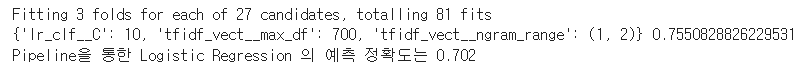

#### 로지스틱 회귀 외에 서포트 벡터머신과 나이브 베이즈 알고리즘도 희소 행렬 기반의 텍스트 분류에 자주 사용되는 알고리즘이다.